# Demand Forecasting Demo on a Rossmann Store Sales dataset

Demand forecasting is a field of predictive analytics which tries to understand and predict customer demand to optimize supply decisions by corporate supply chain and business management.

### Index 
Here, we will consider a real use case and show how to use LSTM for forecasting sales accross 4 stores for a recursive period of 2 weeks.

In particular, we will see how to:

* Prepare the dataset.
    * [Import Store dataset](#Import-Store-dataset)
    * [Data Visualization](#Data-Visualization)
    * [Data Preprocessing](#Data-Preprocessing)
    
    
* [LSTM MODEL BUILDING](#LSTM-MODEL-BUILDING)


* [TRAINING](#TRAINING)


* [TESTING](#TESTING)


* [EVALUATION](#EVALUATION)


* [PLOTS](#PLOTS)


* [NEXT STEPS](#NEXT-STEPS)

###  Installing & Importing required packages

In [17]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install Keras

     |██████████████████████▏         | 292.0 MB 128.5 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 421.8 MB 21 kB/s 
     |████████████████████████████████| 448 kB 96.1 MB/s eta 0:00:01
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
     |████████████████████████████████| 63 kB 4.7 MB/s s eta 0:00:01
     |████████████████████████████████| 3.8 MB 75.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 65.5 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 9.4 MB/s s eta 0:00:01
Processing /home/ubuntu/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd/gast-0.2.2-cp37-none-any.whl
Processing /home/ubuntu/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6/termcolor-1.1.0-cp37-none-any.whl
     |████████████████████████████████| 2.8 MB 67.8 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 121.7 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 14.2 MB/s  eta 0:00:01
     |████████████████████████████████| 89 kB 17.6 MB/s  eta 0:00:

In [1]:
import numpy as np
from numpy import concatenate
import matplotlib
import pandas as pd
from datetime import datetime,date
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras import backend as K
from keras.callbacks import EarlyStopping
import time
import matplotlib.pyplot as plt
from io import StringIO
import os.path
import json

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
### Setting random seed to reproduce the results
np.random.seed(seed=786)
tf.random.set_seed(786)

### Import Store dataset 

Historical sales data for 1,115 Rossmann stores

For more information about data, [kaggle](https://www.kaggle.com/c/rossmann-store-sales/data)

In [3]:
try:
    data = pd.read_csv('train.csv')
    print('data loaded from local')
except:
    !wget https://raw.githubusercontent.com/Peaceful-learner/Kaggle-Rossman-Store-Sales-Challenge/master/train.csv
    data = pd.read_csv('train.csv')
    print('data downloaded and loaded')

--2020-05-04 14:36:29--  https://raw.githubusercontent.com/Peaceful-learner/Kaggle-Rossman-Store-Sales-Challenge/master/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38057952 (36M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  36.29M   182MB/s    in 0.2s    

2020-05-04 14:36:31 (182 MB/s) - ‘train.csv’ saved [38057952/38057952]

data downloaded and loaded


In [4]:
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
# No. of stores
data.Store.nunique()

1115

In [4]:
# Data types
data.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [73]:
# Convert Date type object to datetime
data['Date'] = pd.to_datetime(data['Date'])

In [22]:
data.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

In [74]:
# Filter a single store data
store1data = data.loc[data['Store']==1,['Date','DayOfWeek','StateHoliday','Open','Promo','SchoolHoliday','Sales']]

In [75]:
#Reset index
store1data = store1data.reset_index(drop=True)

In [76]:
# Sort dataframe by Date column
store1data.sort_values(by='Date',inplace=True)

In [77]:
store1data.StateHoliday = store1data['StateHoliday'].apply(lambda x: 1 if x!='0' else x)  #0 is obj not int

In [30]:
#head shows first 5 rows of dataset
store1data.head()

,Date,DayOfWeek,StateHoliday,Open,Promo,SchoolHoliday,Sales
941,2013-01-01,2,1,0,0,1,0
940,2013-01-02,3,0,1,0,1,5530
939,2013-01-03,4,0,1,0,1,4327
938,2013-01-04,5,0,1,0,1,4486
937,2013-01-05,6,0,1,0,1,4997


In [50]:
#tail shows last 5 rows of dataset
store1data.tail()

,Date,DayOfWeek,StateHoliday,Open,Promo,SchoolHoliday,Sales
4,2015-07-27,1,0,1,1,1,6102
3,2015-07-28,2,0,1,1,1,5011
2,2015-07-29,3,0,1,1,1,4782
1,2015-07-30,4,0,1,1,1,5020
0,2015-07-31,5,0,1,1,1,5263


In [32]:
#describe give us the data statistics
store1data[['Sales']].describe()

,Sales
count,942.000000
mean,3945.704883
std,2015.417840
min,0.000000
25%,3588.250000
50%,4373.500000
75%,5220.000000
max,9528.000000


### Data Visualization 

Plotting the time series to check if there is any seasonality


In [11]:
def plot_(index):
    '''
    function to plot date vs sales
    index : number to slice the dataset
    '''
    plt.figure(figsize=(20,8))
    plt.plot(store1data['Date'][:index],store1data['Sales'][:index])
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

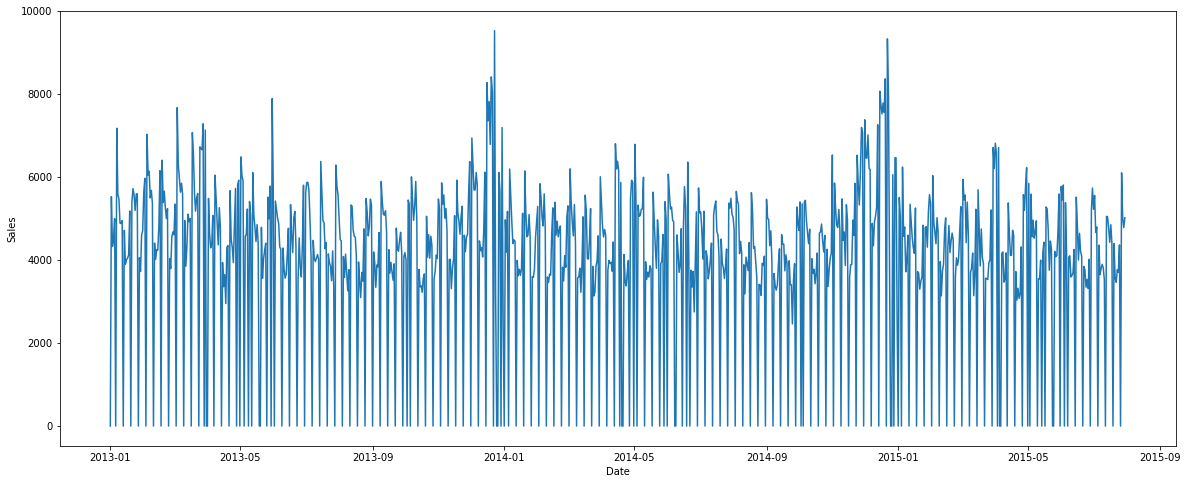

In [15]:
#complete data
plot_(-1)

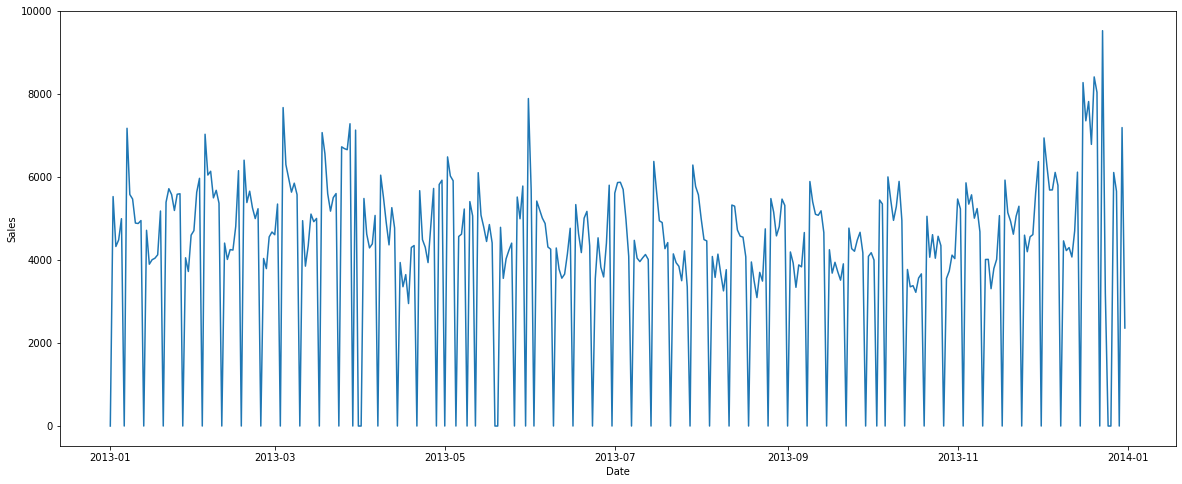

In [16]:
#yearly data
plot_(365)

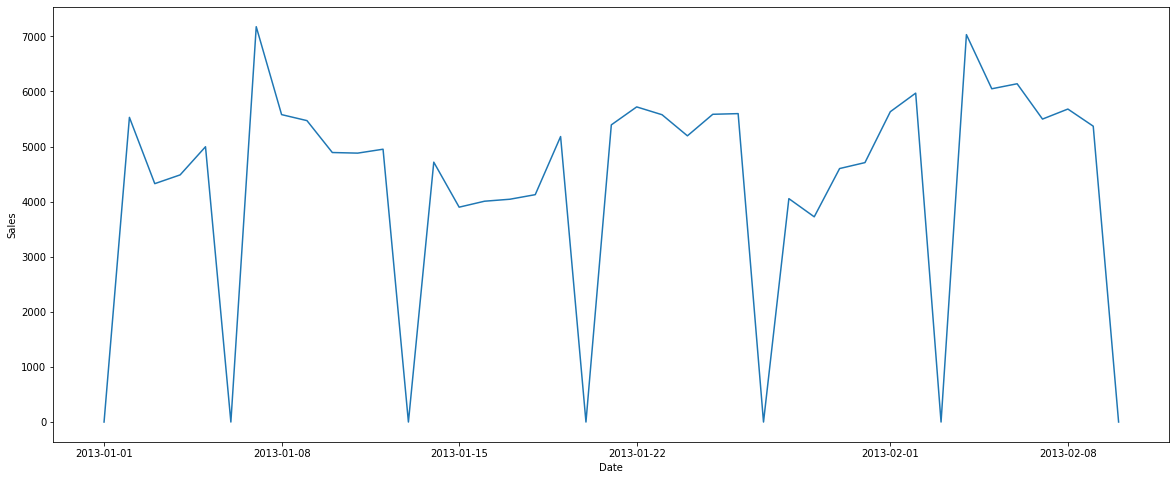

In [17]:
#weekly
plot_(41)

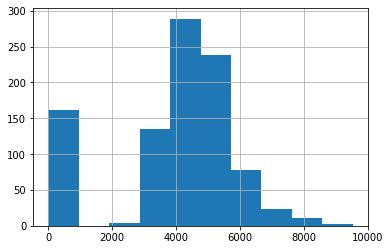

In [18]:
#sales distribution
store1data.Sales.hist()

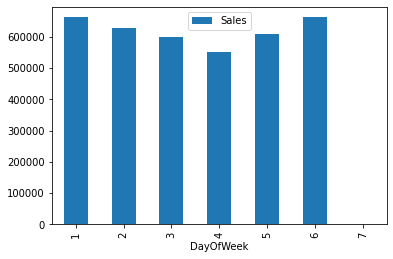

In [19]:
#sales distribution according to DayOfWeek
week_sales = store1data.groupby('DayOfWeek').sum()
week_sales.plot(kind='bar')

### Data Preprocessing

In [78]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    In this function, we convert a time series dataframe into a supervised dataframe 
    where each column represent value of variables at a particular time period such as t, t-1... t-k, t+1... t+n

    Parameters
    ----------
     - Dataframe: Time Series dataframe
     - n_in: Lookback time periods
     - n_out: Horizon time periods
     - dropnan: Remove all nan from the dataframe
     
    Returns: 
    ----------
    - Transformed Dataframe

    '''
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))

        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [79]:
def get_supervised_model_data(data, num_features, lookback, horizon):
    '''
    In this function we transform our dataframe into required form,removing lead columns for sales 
    on series_to_supervised function output
    
    Parameters
    ----------
     - data     : Dataframe
     - num_features : No. of features used for training
     - lookback : No. of days for Past data
     - horizon  : No. of days ahead forecast
     
    Returns:
    ----------
     - reframed.values : Array of data
    
    '''
    
    # Converting the time series to supervised frame    
    reframed = series_to_supervised(data, lookback, horizon)
    print('series to supervised output:\n',reframed.head())
    print('*'*30)
    
    Temp = [x*num_features  for x in list(range(lookback,lookback+horizon-1))]
    reframed.drop(reframed.columns[Temp], axis=1, inplace=True)
    print('training data after dropping lead columns:\n',reframed.head())
    print('*'*30)
    
    # Below snippet will make var1(t+n) the last column in the dataframe. 
    # The is train Y. This is done for the purpose of ease
    y_column = 'var1(t+'+str(horizon-1)+')'
    col_list = reframed.columns.tolist()
    col_list.remove(y_column)
    col_list.extend([y_column])
    reframed = reframed[col_list]

    print('Features:\n',reframed.columns)
    return reframed.values

In [80]:
def robust_scaler_fit_transform(unscaled_arr):
    '''
    In this function, we pass a multidimensional array to return the 
    median and interquartile range of each features used in the model training
    The parameter is expected in this format 
    [[feature(t-1)1, feature(t-1)2, feature(t-1)3], [feature1(t), feature2(t), feature(t)3]]
    
    The shape should be (no of training sample, no of features)
    
    Parameters
    ----------
     - unscaled_arr: The multidimensional array of raw values
    
    Returns: 
    ----------
    - med_list: A list containing median for each feature used in the model
    - iqr_list: A list containing IQR for each feature used in the model
    '''
    nos_features = unscaled_arr.shape[1]
    scaled_arr = np.empty([unscaled_arr.shape[0], unscaled_arr.shape[1]])
    iqr_list = []
    med_list = []
    for i in range(nos_features):
        iqr = np.percentile(unscaled_arr[:,i], 100) - np.percentile(unscaled_arr[:,i], 0)
        med = np.median(unscaled_arr[:,i])
        iqr_list.append(iqr)
        med_list.append(med)
        if iqr != 0:
            scaled_arr[:,i] = (unscaled_arr[:,i] - med)/ np.subtract(*np.percentile(unscaled_arr[:,i], [100, 0]))
        else:
            scaled_arr[:,i] = unscaled_arr[:,i]  
    
    return(med_list, iqr_list)

In [81]:
def robust_scaler_transform(unscaled_arr, med_list, iqr_list):
    '''
    In this function, an unscaled array is transformed 
    based on the values of median and IQR passed to it
    
    Parameters
    ----------
    - unscaled_arr: The multidimensional array of raw values
    - med_list: A list containing median for each feature used in the model
    - iqr_list: A list containing IQR for each feature used in the model
    
    Returns: 
    ----------
    - scaled_arr: Returns the scaled array
    '''
    
    nos_features = unscaled_arr.shape[1]
    scaled_arr = np.empty([unscaled_arr.shape[0], unscaled_arr.shape[1]])
    for i in range(nos_features):
        med = med_list[i]
        iqr = iqr_list[i]
        if iqr != 0:
            scaled_arr[:,i] = (unscaled_arr[:,i] - med)/ iqr
        else:
            scaled_arr[:,i] = unscaled_arr[:,i]  
    
    return(scaled_arr)

In [82]:
def robust_scaler_inverse_transform(yhat, med_list, iqr_list):
    '''
    In this function, a scaled array is transformed 
    based on the values of median and IQR passed to it
    
    Parameters
    ----------
    - yhat: The multidimensional array of scaled values
    - med_list: A list containing median for each feature used in the model
    - iqr_list: A list containing IQR for each feature used in the model
    
    Returns: 
    ----------
    - inv_yhat: Returns the raw data array
    '''
    
    nos_features = yhat.shape[1]
    inv_yhat = np.empty([yhat.shape[0], yhat.shape[1]])
    for i in range(nos_features):
        med = med_list[i]
        iqr = iqr_list[i]
        if iqr != 0:
            inv_yhat[:,i] = (yhat[:,i] * iqr) + med
        else:
            inv_yhat[:,i] = yhat[:,i]

    return(inv_yhat)

In [83]:
def get_scaled_data(feat_df, num_train_days, scale=False):
    '''
    In this funciton, we scale our data with RobustScaler
    
    Parameters
    ----------
     - feat_df        : Dataframe consisting of features to train
     - num_train_days : No. of days for training
     - scale          : whether to scale data or no, boolean(True/False)
     
     Returns:
     ----------
      - scaled      : Scaled data if scale=True else feat_df
      - median_list : A list containing median for each feature used in the model if scale=True else None
      - iqr_list    : A list containing IQR for each feature used in the model if scale=True else None
    '''
    
    if scale:
        scaler = RobustScaler(quantile_range=(0,100))
        splitTrainTest = num_train_days
        scaledTrainValues = scaler.fit_transform(feat_df[:splitTrainTest, :])
        median_list, iqr_list = robust_scaler_fit_transform(feat_df[:splitTrainTest, :])
        scaledTestValues = robust_scaler_transform(feat_df[splitTrainTest:, :], median_list, iqr_list)
        scaled = np.append(arr=scaledTrainValues, values=scaledTestValues,axis=0)
        return scaled, median_list, iqr_list
    
    else:
        return feat_df, None, None

In [84]:
def get_train_test_data(data, feat_df, features, lookback, horizon, training_cutoff, num_features, scale):
    '''
    In this function, we split our dataframe into train and test set
    
    Parameters
    ----------
     - data            : Complete Dataframe
     - feat_df         : Dataframe consisting of features to train
     - features        : features used for training
     - lookback        : No. of days for Past data
     - horizon         : No. of days ahead forecast
     - training_cutoff : Date till where to train the model
     - scale           : whether to scale data or no, boolean(True/False)
     
    Returns
    ----------
     - train_X : Data for training
     - train_y : Labels for train_X
     - test_X  : Data for testing
     - test_y  : Lables for test_X
    '''
    
    data = data.reset_index()
    d = data[data['Date']<=pd.to_datetime(training_cutoff)]
    num_train_days = d.shape[0]

    scaled, median_list, iqr_list = get_scaled_data(feat_df, num_train_days, scale)     
    Newvalues = get_supervised_model_data(scaled, num_features, lookback, horizon)
    
    train = Newvalues[:num_train_days, :]
    print('*'*30)
    print('No. of training samples:',len(train))
    test = Newvalues[num_train_days:, :] #
    print('No. of testing samples:',len(test))
    
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))    

    return train_X, train_y, test_X, test_y, median_list, iqr_list

In [102]:
training_cutoff = '2014-12-31'
lookback = 15
horizon = 14

features = ['Sales','DayOfWeek','StateHoliday']
# features = ['Sales','DayOfWeek','StateHoliday','Open','Promo','SchoolHoliday']

feat_df = store1data[features].values.astype('float32')
num_features = feat_df.shape[1]

neuron = 100
epochs = 25

scale = True

In [104]:
train_X, train_y, test_X, test_y, median_list, iqr_list = \
get_train_test_data(store1data, feat_df, features, lookback, horizon, training_cutoff, num_features, scale)

series to supervised output:
     var1(t-15)  var2(t-15)  var3(t-15)  var1(t-14)  var2(t-14)  var3(t-14)  \
15   -0.464945   -0.333333         1.0    0.115449   -0.166667         0.0   
16    0.115449   -0.166667         0.0   -0.010810    0.000000         0.0   
17   -0.010810    0.000000         0.0    0.005877    0.166667         0.0   
18    0.005877    0.166667         0.0    0.059509    0.333333         0.0   
19    0.059509    0.333333         0.0   -0.464945    0.500000         0.0   

    var1(t-13)  var2(t-13)  var3(t-13)  var1(t-12)  ...  var3(t+10)  \
15   -0.010810    0.000000         0.0    0.005877  ...         0.0   
16    0.005877    0.166667         0.0    0.059509  ...         0.0   
17    0.059509    0.333333         0.0   -0.464945  ...         0.0   
18   -0.464945    0.500000         0.0    0.288203  ...         0.0   
19    0.288203   -0.500000         0.0    0.120697  ...         0.0   

    var1(t+11)  var2(t+11)  var3(t+11)  var1(t+12)  var2(t+12)  var3(t+12)

### LSTM MODEL BUILDING

In [34]:
def train(train_X, train_y):
    '''
    Parameters
    ----------
        train_X : Data for training
        train_y : Labels corresponding to train_X
    
    Returns
    ----------
        model : Model object 
        history : Records training metrics for each epoch
    '''
    callback = [EarlyStopping(monitor='val_loss', patience = 5, mode = 'min')]
    
    model = Sequential()
    model.add(LSTM(units=neuron,input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences = False))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    history = model.fit(train_X, train_y, epochs=epochs, validation_split=0.20,\
                                    batch_size=64, verbose=2, shuffle=False, callbacks=callback)

    return model, history

### TRAINING

In [61]:
model, history = train(train_X, train_y)

Train on 584 samples, validate on 146 samples
Epoch 1/25
 - 0s - loss: 0.1476 - val_loss: 0.1487
Epoch 2/25
 - 0s - loss: 0.1266 - val_loss: 0.1092
Epoch 3/25
 - 0s - loss: 0.1188 - val_loss: 0.1233
Epoch 4/25
 - 0s - loss: 0.0787 - val_loss: 0.1030
Epoch 5/25
 - 0s - loss: 0.0754 - val_loss: 0.0940
Epoch 6/25
 - 0s - loss: 0.0748 - val_loss: 0.0929
Epoch 7/25
 - 0s - loss: 0.0791 - val_loss: 0.0891
Epoch 8/25
 - 0s - loss: 0.0824 - val_loss: 0.1033
Epoch 9/25
 - 0s - loss: 0.0747 - val_loss: 0.0892
Epoch 10/25
 - 0s - loss: 0.0730 - val_loss: 0.0965
Epoch 11/25
 - 0s - loss: 0.0714 - val_loss: 0.0881
Epoch 12/25
 - 0s - loss: 0.0717 - val_loss: 0.0935
Epoch 13/25
 - 0s - loss: 0.0738 - val_loss: 0.0885
Epoch 14/25
 - 0s - loss: 0.0766 - val_loss: 0.0997
Epoch 15/25
 - 0s - loss: 0.0729 - val_loss: 0.0893
Epoch 16/25
 - 0s - loss: 0.0728 - val_loss: 0.0996


- The model is evaluated on the validation dataset at the end of each training epoch

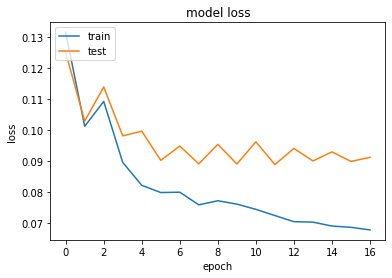

In [45]:
# visualize train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

From the loss plot above, we can see that the model has not comparable performance on both train and validation datasets,as these parallel plots depart from each other.

### TESTING

In [55]:
def get_predictions(data, store, features_for_output_df, model, test_X, test_y, \
                             num_features, median_list, iqr_list, scale):
    # Predictions
    yhat = model.predict(test_X)
    df = pd.DataFrame(columns=features_for_output_df)
    
    if scale:
        if (test_X.shape[0]==0):
            print('location no.:',store)
            print("****no testing data****")
            df = pd.DataFrame(columns=features_for_output_df)
        else:
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((yhat, test_X[:, 1:num_features]), axis=1)
            inv_yhat = robust_scaler_inverse_transform(inv_yhat, median_list, iqr_list)
            inv_yhat = inv_yhat[:,0]

            # invert scaling for actual
            test_y = test_y.reshape((len(test_y), 1))
            inv_y = concatenate((test_y, test_X[:, 1:num_features]), axis=1)
            inv_y = robust_scaler_inverse_transform(inv_y, median_list, iqr_list)
            inv_y = inv_y[:,0]

            df['Truth'] = np.round(inv_y,2)
            df['Pred'] = inv_yhat
            df['MAPE'] = np.abs(df['Truth'] - df['Pred'])/df['Truth']*100
            
    else:
        df['Truth'] = test_y
        df['Pred'] = yhat
        df['MAPE'] = np.abs(df['Truth'] - df['Pred'])/df['Truth']*100
    
    return df

features_for_output_df = ['Truth', 'Pred','MAPE']
df = get_predictions(store1data, 1, features_for_output_df, model, test_X, test_y, \
                             num_features, median_list, iqr_list, scale)

In [47]:
print(df.head())

    Truth         Pred       MAPE
0  5171.0  4281.331081  17.204968
1  5577.0  4875.792510  12.573202
2  5363.0  5024.055797   6.320049
3    -0.0   -49.227949       -inf
4  6038.0  4926.048734  18.415887


### EVALUATION

In [24]:
#No data scaling
print('MAPE:',np.mean(df[df['Truth']!=0]['MAPE']))

MAPE: 88.37796


In [26]:
# with data Scaling
print('MAPE:',np.mean(df[df['Truth']!=0]['MAPE']))

MAPE: 14.118140716926234


In [56]:
# with data Scaling and additional features
print('MAPE:',np.mean(df[df['Truth']!=0]['MAPE']))

MAPE: 10.540665303291819


### PLOTS

In [40]:
# to plot the actual and forecast values
def plty(Result):
    plt.figure(figsize=(18,8))
    plt.plot(Result['Truth'],label='Truth')
    plt.plot(Result['Pred'],label='Pred')
    plt.legend()
    plt.show()

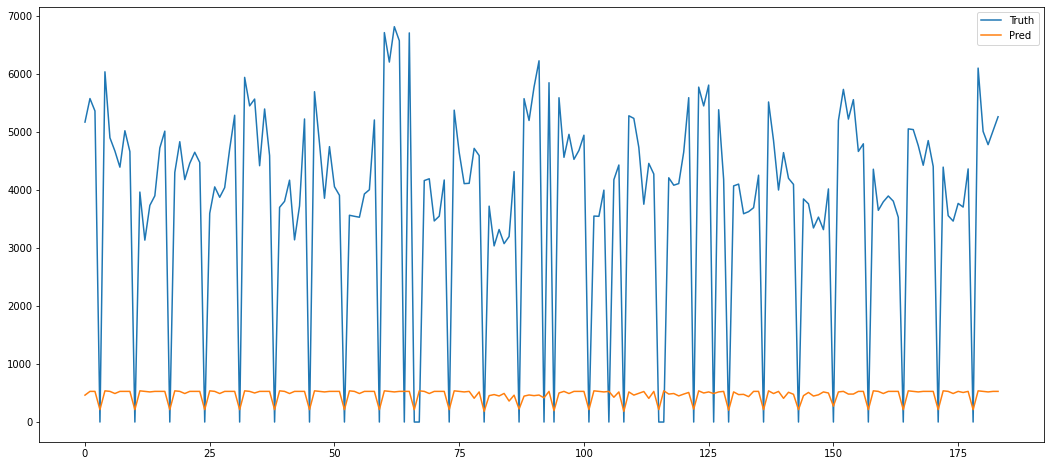

In [26]:
# No scaling
plty(df)

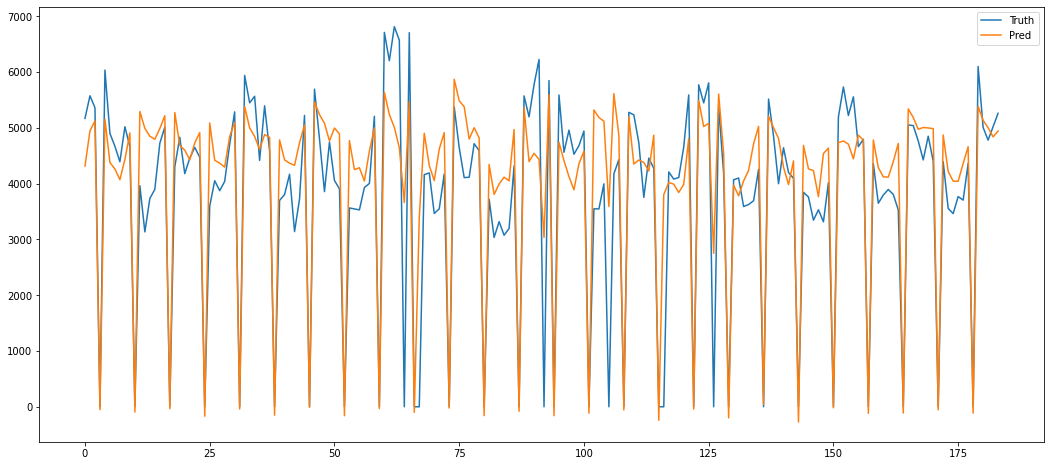

In [29]:
# with scaling
plty(df)

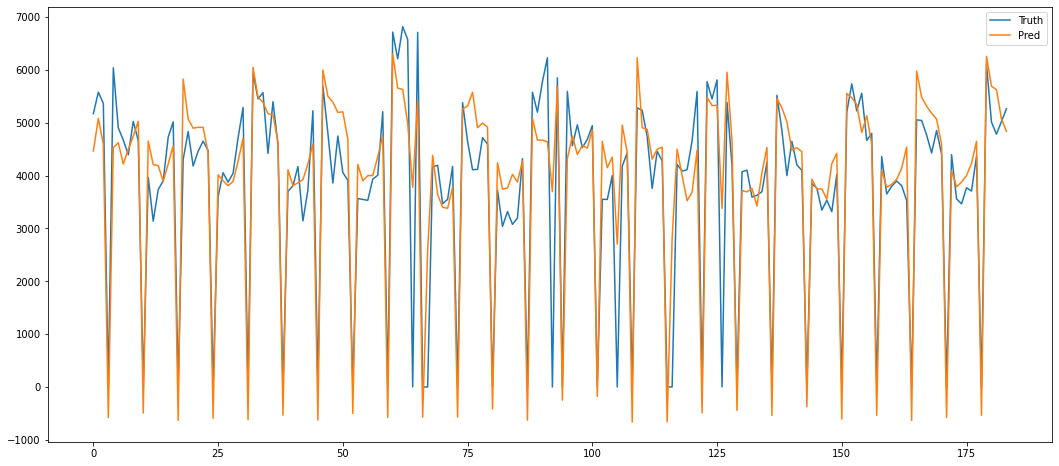

In [57]:
# with scaling and additional features
plty(df)

### NEXT STEPS

- Hyperparameter Tunining, play around with no. of neurons,epochs,batch_size,lookback,horizon,training_cutoff
- Try removing sundays,dayofweek=7 as it has sales value 0 and analyze the forecast